# Machine Learning Engineer Nanodegree
## Capstone Proposal
## TalkingData AdTracking Fraud Detection Challenge

> Adding necessary libraries

In [42]:
import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import pickle
import time

from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

%matplotlib inline

> Readind .csv files with the data (train and test)

In [2]:
train = pd.read_csv('data/train_sample.csv', parse_dates=['click_time', 'attributed_time'])
test = pd.read_csv('data/test.csv', parse_dates=['click_time'])

> Some views of the train and test dataframes

In [3]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [31]:
train.describe()

,ip,app,device,os,channel,is_attributed
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,86993.581653,12.316655,26.141368,23.067662,241.523634,0.001693
std,55529.023541,16.216890,273.537010,55.323313,122.713405,0.041111
min,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42297.000000,3.000000,1.000000,13.000000,134.000000,0.000000
50%,81725.000000,12.000000,1.000000,18.000000,232.000000,0.000000
75%,120440.000000,15.000000,1.000000,19.000000,280.000000,0.000000
max,212773.000000,645.000000,3379.000000,715.000000,498.000000,1.000000


In [32]:
test.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [33]:
test.describe()

,click_id,ip,app,device,os,channel
count,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07,1.879047e+07
mean,9.395234e+06,6.306921e+04,1.221480e+01,1.730513e+00,1.873312e+01,2.648059e+02
std,5.424341e+06,3.688597e+04,1.164924e+01,2.597038e+01,1.135059e+01,1.355254e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.697617e+06,3.155800e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.350000e+02
50%,9.395234e+06,6.393600e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.360000e+02
75%,1.409285e+07,9.531600e+04,1.800000e+01,1.000000e+00,1.900000e+01,4.010000e+02
max,1.879047e+07,1.264130e+05,5.210000e+02,3.031000e+03,6.040000e+02,4.980000e+02


In [36]:
train.dtypes

ip                  int64
app                 int64
device              int64
os                  int64
channel             int64
click_time         object
attributed_time    object
is_attributed       int64
dtype: object

In [74]:
train.groupby('ip')['device'].count().describe()

count    39611.000000
mean        25.245513
std         84.288111
min          1.000000
25%          3.000000
50%         10.000000
75%         25.000000
max       6437.000000
Name: device, dtype: float64

#### Observations ####

* Only 0.17% downloads vs 99.83% non-downloads, or only 17 clicks in every 10,000 result in downloads.
* All records in `train` are recorded in 4 days, starting from 2017-11-06. All records in `test` are recorded on 2017-11-10. Hence, `train` and `test` data are not overlapped; some time-based features such as the day of the week the click is generated, or whether the click is during a holiday / event, etc. are unusable.
* Each `ip` can have multiple `device`s. Perhaps these are public IP addresse of cafe, public places, university, etc.
* The distribution of target variable `is_attributed` is heavily skewed.

### Tuning classifier parameters

In [3]:
train = pd.read_csv('data/train_sample.csv', nrows=100000, parse_dates=['click_time', 'attributed_time'])

X_train = train[['ip', 'app', 'device', 'os', 'channel']]
y_train = train['is_attributed']

> Searching for best parameters in terms of the area under the ROC curve metric as per the competition evaluation metrics.

In [22]:
params = {
    'max_depth': list(range(5, 11)),
    'learning_rate': list(np.arange(0.05, 0.30, 0.05)),
    'gamma': list(np.arange(0.01, 0.06, 0.01)),
    'min_child_weight': list(range(1, 6)),
    'max_delta_step': list(range(10, 22, 2)),
    'colsample_bytree': list(np.arange(0.5, 1.1, 0.1)),
    'reg_lambda': [1000, 2000, 3000],
    
    # fixed params
    'scale_pos_weight': [99], # Because 99 percent of data is negative
    'n_jobs': [4],
    'objective': ['binary:logistic'],
    'random_state': [42]
}

model = xgb.XGBClassifier(tree_method='hist')
cv = GridSearchCV(model, params, cv=5, n_jobs=4, scoring='roc_auc')

cv.fit(X_train, y_train)

In [41]:
print('Best estimator:')
print(cv.best_estimator_)

score = cv.best_estimator_.predict_proba(X_train)
print('Best ROC-AUC: {:.4f}'.format(metrics.roc_auc_score(y_train, score[:, 1], average='macro')))

Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.7, gamma=0.03, learning_rate=0.15,
       max_delta_step=20, max_depth=6, min_child_weight=4, missing=None,
       n_estimators=100, n_jobs=4, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1000, scale_pos_weight=99, seed=None, silent=True,
       subsample=1.0, tree_method='hist')
Best ROC-AUC: 0.9733


## Feature Engineering ##

### Extract clicking time into day, hour, minute: ###

In [2]:
def processTimeFeatures(df):
    df['click_day'] = df.click_time.dt.day

    df['click_hour'] = df.click_time.dt.hour

    df['click_minute'] = df.click_time.dt.minute
    
    df.drop(['click_time'], axis=1, inplace=True)

In [4]:
processTimeFeatures(train)
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_day,click_hour,click_minute
0,83230,3,1,13,379,2017-11-06 14:32:21,NaT,0,6,14,32
1,17357,3,1,19,379,2017-11-06 14:33:34,NaT,0,6,14,33
2,35810,3,1,13,379,2017-11-06 14:34:12,NaT,0,6,14,34
3,45745,14,1,13,478,2017-11-06 14:34:52,NaT,0,6,14,34
4,161007,3,1,13,379,2017-11-06 14:35:08,NaT,0,6,14,35


In [5]:
test = processTimeFeatures(test)
test.head()

,click_id,ip,app,device,os,channel,click_time,click_day,click_hour,click_minute
0,0,5744,9,1,3,107,2017-11-10 04:00:00,10,4,0
1,1,119901,9,1,3,466,2017-11-10 04:00:00,10,4,0
2,2,72287,21,1,19,128,2017-11-10 04:00:00,10,4,0
3,3,78477,15,1,13,111,2017-11-10 04:00:00,10,4,0
4,4,123080,12,1,13,328,2017-11-10 04:00:00,10,4,0


### Return rate:

In [3]:
def getAvgAppClickPerIp(df):
    df['avg_app_click_by_ip'] = df[['app', 'ip']].groupby('app')['ip'].agg(lambda x: float(len(x)) / len(x.unique()))

In [54]:
getAvgAppClickPerIp(train)

In [55]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,avg_app_click_by_ip,time_to_next_click
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,NaN,NaN
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,1.151304,NaN
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,1.512695,NaN
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,1.518189,NaN
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,1.035714,NaN


In [59]:
train.avg_app_click_by_ip.describe()

count    161.000000
mean       1.042851
std        0.100990
min        1.000000
25%        1.000000
50%        1.000000
75%        1.027778
max        1.518189
Name: avg_app_click_by_ip, dtype: float64

### Time until next click:

In [4]:
def getTimeToNextClick(df):
    df['time_to_next_click'] = df[['ip', 'os', 'device', 'channel', 'click_time']]\
                                .groupby(['ip', 'os', 'device', 'channel'])['click_time']\
                                .transform(lambda x: x.diff().shift(-1).dt.seconds)

In [36]:
getTimeToNextClick(train)
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,avg_app_click_by_ip,time_to_next_click
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,NaN,NaN
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,1.151304,NaN
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,1.512695,NaN
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,1.518189,NaN
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,1.035714,NaN


In [58]:
train.time_to_next_click.describe()

count     2739.000000
mean     43177.566995
std      27415.967224
min          0.000000
25%      17704.500000
50%      43738.000000
75%      68569.000000
max      86399.000000
Name: time_to_next_click, dtype: float64

### Preprocessing data and write to files for future reuse ###

In [5]:
train = pd.read_csv('data/train.csv', skiprows=range(1, 84903892), nrows=60000000, parse_dates=['click_time', 'attributed_time'])

getAvgAppClickPerIp(train)
getTimeToNextClick(train)

train.to_csv('data/train_60mil_with_avgClick_timeToNext.csv')

del train

In [7]:
test = pd.read_csv('data/test.csv', parse_dates=['click_time'])

getAvgAppClickPerIp(train)
getTimeToNextClick(train)

test.to_csv('data/test_with_avgClick_timeToNext.csv')

del test

## Train and test model ##

In [10]:
num_rows = 60000000
start = 0
batch_size = 20000000

params = {
    'max_depth': 6,
    'learning_rate': 0.15,
    'objective': 'binary:logistic',
    'n_jobs': 3,
    'random_state': 42,
    'gamma': 0.03,
    'min_child_weight': 4,
    'max_delta_step': 20,
    'colsample_bytree': 0.7,
    'reg_lambda': 1000,
    'scale_pos_weight': 99, # Because 99 percent of data is negative
    'tree_method': 'gpu_hist',
    'predictor':'cpu_predictor' # To avoid Windows Error
}

feats = [ # features to train
    'ip',
    'app',
    'device',
    'os',
    'channel',
    'click_day',
    'click_hour',
    'click_minute',
    'avg_app_click_by_ip'
]

model = None
# model_filename = None
cur_done = start
# for cur_done in range(start, num_rows, batch_size):
while cur_done < num_rows:
    
    start_time = time.time()
    
    train = pd.read_csv('data/train_60mil_with_avgClick_timeToNext.csv', skiprows=range(start+1, cur_done+1), nrows=batch_size, parse_dates=['click_time', 'attributed_time'])

    train = processTimeFeatures(train)
    
    dmatrix = xgb.DMatrix(train[feats], train['is_attributed'], feature_names=feats)
    model = xgb.train(params, dmatrix, xgb_model=model, num_boost_round=100) # num_boost_round equivalent to n_estimators in XGBClassifier
#     model_filename = 'models/model'
#     model.save_model(model_filename)
    
    del train
    
    elapsed = time.time() - start_time
    
    cur_done += batch_size
    left = num_rows - cur_done
    if left == 0:
        break
    batch_size = min(left, batch_size)

    print("\rProgress = {:9d}, batch size = {:8d}, left = {:9d}, elapsed = {:s}".format(
        cur_done, batch_size, left,str(datetime.timedelta(seconds=elapsed))))

Progress =  20000000, batch size = 20000000, left =  40000000, elapsed = 0:05:01.991180
Progress =  40000000, batch size = 20000000, left =  20000000, elapsed = 0:07:09.987097
Progress =  60000000, batch size = 20000000, left =         0, elapsed = 0:10:48.966723



In [14]:
test = pd.read_csv('data/test_with_avgClick_timeToNext.csv', parse_dates=['click_time'])
processTimeFeatures(test)

pred = model.predict(xgb.DMatrix(test[feats], feature_names=feats))

In [15]:
sub = pd.DataFrame(pred, np.array(test['click_id']), columns=['is_attributed'])

(1806190601) Score: (60 mil)

(1806170429) Score: 0.9536322 (all)

(1806140722) Score: 0.5417372 (10 mil)

(1806140637) Score: 0.5363756

(1806130416) Score: 0.5000000

In [16]:
sub.to_csv('submissions/xgb_with_xgb_params_acpi_ttnc_60mil.csv', index_label=['click_id'])

In [18]:
pickle.dump(model, open('models/xgb_test.pickle.dat', 'wb'))

## Feature importance

In [46]:
train = pd.read_csv('data/train.csv', nrows=10000000, parse_dates=['click_time', 'attributed_time'])

In [47]:
groups = [    
    {'groupby': ['ip']},
    {'groupby': ['ip', 'app']},
    {'groupby': ['ip', 'channel']},
    {'groupby': ['ip', 'os']},
    {'groupby': ['ip', 'app', 'device', 'os', 'channel']},
    {'groupby': ['ip', 'os', 'device']},
    {'groupby': ['ip', 'os', 'device', 'app']}
]

# Calculate the time to next click for each group
for gr in groups:
    start_time = time.time()
    
    feature_name = '{}_time_to_next_click'.format('_'.join(gr['groupby']))        
    all_features = gr['groupby'] + ['click_time']

    train[feature_name] = train[gr['groupby'] + ['click_time']].\
                            groupby(gr['groupby']).click_time.\
                            transform(lambda x: x.diff().shift(-1)).dt.seconds
    elapsed = time.time() - start_time
    
    print('Done {:s}, in {:s}'.format(feature_name, str(datetime.timedelta(seconds=elapsed))))
train.head()

Done ip_time_to_next_click, in 0:00:33.599123
Done ip_app_time_to_next_click, in 0:06:34.713769
Done ip_channel_time_to_next_click, in 0:13:26.728573
Done ip_os_time_to_next_click, in 0:04:14.371852
Done ip_app_device_os_channel_time_to_next_click, in 0:35:53.558182
Done ip_os_device_time_to_next_click, in 0:04:25.667189
Done ip_os_device_app_time_to_next_click, in 0:21:06.699604


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,ip_time_to_next_click,ip_app_time_to_next_click,ip_channel_time_to_next_click,ip_os_time_to_next_click,ip_app_device_os_channel_time_to_next_click,ip_os_device_time_to_next_click,ip_os_device_app_time_to_next_click
0,83230,3,1,13,379,2017-11-06 14:32:21,NaT,0,5290.0,5340.0,5444.0,5307.0,8889.0,5307.0,5340.0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaT,0,5177.0,5177.0,5177.0,5239.0,NaN,5239.0,5547.0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaT,0,5175.0,5175.0,6005.0,5205.0,NaN,5205.0,5925.0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaT,0,5108.0,5110.0,5137.0,5108.0,13882.0,5108.0,5110.0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaT,0,6431.0,6431.0,9423.0,27338.0,33841.0,27338.0,33756.0


In [48]:
train.to_csv('data/train_time_features_10mil.csv')

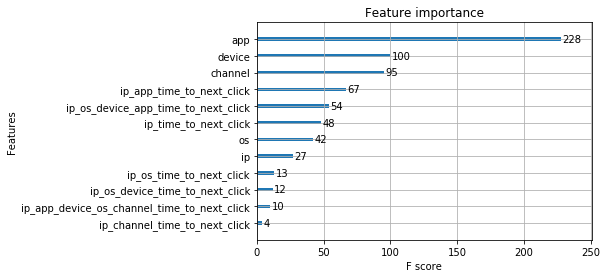

In [51]:
features = [
    'ip',
    'app',
    'device',
    'os',
    'channel',
    'ip_time_to_next_click',
    'ip_app_time_to_next_click',
    'ip_channel_time_to_next_click',
    'ip_os_time_to_next_click',
    'ip_app_device_os_channel_time_to_next_click',
    'ip_os_device_time_to_next_click',
    'ip_os_device_app_time_to_next_click'
]

model = xgb.XGBClassifier()
model.fit(train[features], train['is_attributed'])

xgb.plot_importance(model)
plt.show()